1. Aggregate the JSON File tiestamps based on 15 minute intervals 
2. Visualize/Describe timeseries of login counts in whats that best describe patterns of demand. i.e. *Daily Cycles* 
3. Identify quality issues
4. What are the fraction of user retained

### Imports

In [41]:
import json
import pandas as pd
import numpy as np

In [2]:
#Opeing JSON file 
f = open('../raw_data/logins.json')
f1 = open('../raw_data/ultimate_data_challenge.json')

#Return JSON object as dictionary
logins = json.load(f)
dmet = json.load(f1)

In [3]:
#Convert login dictionary to dataframes
logins = pd.DataFrame.from_dict(logins)

#Convert driver metric dictionary to dataframe 
dmet = pd.DataFrame.from_dict(dmet)


In [4]:
logins.head(10)

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21
5,1970-01-01 20:21:41
6,1970-01-01 20:12:16
7,1970-01-01 20:35:47
8,1970-01-01 20:35:38
9,1970-01-01 20:47:52


In [5]:
from datetime import datetime, timedelta 

#Convert Range Index to Array 
arr = logins.to_numpy()

#Convert objects to timestamps
time_arr = [pd.to_datetime(x, format="%Y-%m-%d %H:%M:%S", errors='coerce') for x in arr]

#Convert to DataFrame
time_df = pd.DataFrame(time_arr)

In [6]:
def feature_eng(df):
    #Round to nearest 15 MINUTES
    df['15 min inc'] = df[0].dt.round('15min')
    
    # Convert date data to ordinal for use with linear regression graph 
    df["time in ord"]= df["15 min inc"].map(datetime.toordinal)
    
    #Create DAILY CYCLE features
    df["date"] = [x.date() for x in df["15 min inc"]]
    df["date"] = df["date"].map(lambda x: x.replace(year=2014))
    df["time"] = [x.time() for x in df["15 min inc"]]
    df["month"] = [x.month for x in df["date"]]
    df["day"] = [x.day for x in df["date"]]
    df["hour"] = [x.hour for x in df["time"]]
    df["DayofWeek"] = [(x.weekday() + 1) for x in df["date"]]
    df['begin_of_month'] = (df['day'] < 10).astype('int32')
    df['middle_of_month'] = ((df['day'] >= 10) & (df['day'] < 20)).astype('int32')
    df['end_of_month'] = (df['day'] >= 20).astype('int32')
    df['morning'] = df['hour'].map(lambda x: 1 if (x <= 11)& (x >= 7) else 0).astype('int32')
    df['afternoon'] = df['hour'].map(lambda x: 1 if (x >= 12) & (x <= 18) else 0).astype('int32')
    df['evening'] = df['hour'].map(lambda x: 1 if (x >= 19) & (x <= 23) else 0).astype('int32')
    df['night'] = df['hour'].map(lambda x: 1 if (x >= 0) & (x <= 6) else 0).astype('int32')
    df['winter'] = df['month'].map(lambda x: x in [12, 1, 2]).astype('int32')
    df['spring'] = df['month'].map(lambda x: x in [3, 4, 5]).astype('int32')
    df['summer'] = df['month'].map(lambda x: x in [6, 7, 8]).astype('int32')
    df['autumn'] = df['month'].map(lambda x: x in [9, 10, 11]).astype('int32')
    df['weekend'] = (df['DayofWeek'] >= 5).astype('int32') 
    df['weekday'] = (df['DayofWeek'] < 5).astype('int32')
    
    return df.drop(0, axis=1)

In [7]:
df = feature_eng(time_df)
df.tail()

,15 min inc,time in ord,date,time,month,day,hour,DayofWeek,begin_of_month,middle_of_month,...,morning,afternoon,evening,night,winter,spring,summer,autumn,weekend,weekday
93137,1970-04-13 18:45:00,719265,2014-04-13,18:45:00,4,13,18,7,0,1,...,0,1,0,0,0,1,0,0,1,0
93138,1970-04-13 18:45:00,719265,2014-04-13,18:45:00,4,13,18,7,0,1,...,0,1,0,0,0,1,0,0,1,0
93139,1970-04-13 19:00:00,719265,2014-04-13,19:00:00,4,13,19,7,0,1,...,0,0,1,0,0,1,0,0,1,0
93140,1970-04-13 19:00:00,719265,2014-04-13,19:00:00,4,13,19,7,0,1,...,0,0,1,0,0,1,0,0,1,0
93141,1970-04-13 19:00:00,719265,2014-04-13,19:00:00,4,13,19,7,0,1,...,0,0,1,0,0,1,0,0,1,0


In [8]:
col = ["month","weekend", "weekday", "begin_of_month", "middle_of_month", "end_of_month", "morning", "afternoon", "evening", "night", "winter", "spring", "summer", "autumn"]
daily_df = pd.DataFrame(df, columns=col)

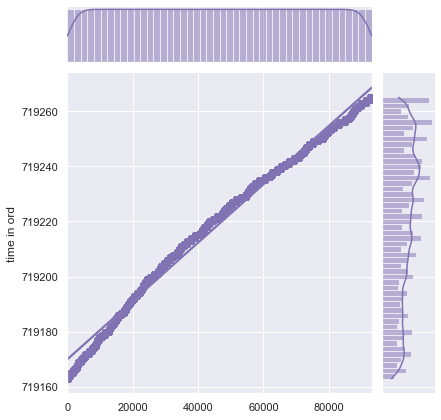

In [9]:
import seaborn as sns 

sns.set_theme(style="darkgrid")

#Graph the values in a jointplot 
g = sns.jointplot(data=df['time in ord'], 
                  kind="reg",
                  color="m")

In [10]:
monthly_fre = daily_df.groupby("month").sum()
monthly_fre.T

month,1,2,3,4
weekend,10221,12222,17173,6839
weekday,11014,12448,16550,6675
begin_of_month,5520,6957,9293,9342
middle_of_month,7562,8385,11496,4172
end_of_month,8153,9328,12934,0
morning,2640,3093,4070,1544
afternoon,5804,6200,8532,3291
evening,5283,6859,9482,3640
night,7508,8518,11639,5039
winter,21235,24670,0,0


### Login Analysis

Given the number of days in a week and number of days in a weekend it appears as though the number of people that are logging in on the weekend outnumber the number of people that are logging in during the week. There is an increase of logins for each attribute as the months progress until you get to April and this data only includes half of the month. The monthly login cycle is lower in the beginning and increases throughout and is highest at the end of each month. There are less logins during the morning increases in the afternoon and is at peak during the night. This include partial data for spring and winter none of the other season are included. 

### Quality Issues 

Quality issues with this data are that the timestamps were simulated and at the "beginning of time" 1970-01-01. I inferred the date based on the information that was given in the pdf. There is no indication of any timezone. The morning, afternoon and night calculation could be skewed by this lack of information. The seasonal trend is based on a US timezones. 

In [11]:
dmet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [12]:
dmet[['avg_rating_of_driver','avg_rating_by_driver']].isna().sum()

avg_rating_of_driver    8122
avg_rating_by_driver     201
dtype: int64

In [16]:
dmet.groupby('city').count()

,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
city,,,,,,,,,,,
Astapor,16534,16534,13647,16534,16534,16413,16534,16534,16534,16534,16476
King's Landing,10130,10130,8847,10130,10130,10066,10130,10130,10130,10130,10090
Winterfell,23336,23336,19384,23336,23336,23125,23336,23336,23336,23336,23233


In [50]:
drivers = dmet[["city", "trips_in_first_30_days", "signup_date", "last_trip_date", "weekday_pct", "avg_dist"]]
drivers.head(5)

,city,trips_in_first_30_days,signup_date,last_trip_date,weekday_pct,avg_dist
0,King's Landing,4,2014-01-25,2014-06-17,46.2,3.67
1,Astapor,0,2014-01-29,2014-05-05,50.0,8.26
2,Astapor,3,2014-01-06,2014-01-07,100.0,0.77
3,King's Landing,9,2014-01-10,2014-06-29,80.0,2.36
4,Winterfell,14,2014-01-27,2014-03-15,82.4,3.13


In [51]:
drivers['last_trip_date'].max()

'2014-07-01'

In [52]:
drivers['signup_date'].min()

'2014-01-01'

In [53]:
drivers['signup_date'] = pd.to_datetime(drivers.loc[:,'signup_date'])
drivers['last_trip_date'] = pd.to_datetime(drivers.loc[:,'last_trip_date'])
drivers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    50000 non-null  object        
 1   trips_in_first_30_days  50000 non-null  int64         
 2   signup_date             50000 non-null  datetime64[ns]
 3   last_trip_date          50000 non-null  datetime64[ns]
 4   weekday_pct             50000 non-null  float64       
 5   avg_dist                50000 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1), object(1)
memory usage: 2.3+ MB


<ipython-input-53-bc4b3f46518e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  drivers['signup_date'] = pd.to_datetime(drivers.loc[:,'signup_date'])
<ipython-input-53-bc4b3f46518e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  drivers['last_trip_date'] = pd.to_datetime(drivers.loc[:,'last_trip_date'])


In [54]:
drivers['months_with_company'] = ((drivers['last_trip_date'] - drivers['signup_date']) / np.timedelta64(1, 'M'))
drivers['months_with_company'] = drivers['months_with_company'].astype(int)

<ipython-input-54-39e91c503fdb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  drivers['months_with_company'] = ((drivers['last_trip_date'] - drivers['signup_date']) / np.timedelta64(1, 'M'))
<ipython-input-54-39e91c503fdb>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  drivers['months_with_company'] = drivers['months_with_company'].astype(int)


In [89]:
retention = drivers.groupby(['months_with_company']).count()
retention['count'] = retention['city']
total_drivers = retention['count'].sum()
retention['frac_ret'] = (retention['count']/total_drivers)
retention[['count','frac_ret']]

,count,frac_ret
months_with_company,,
0,13027,0.26054
1,4036,0.08072
2,4615,0.09230
3,6075,0.12150
4,11053,0.22106
5,11194,0.22388


In [81]:
retention = drivers.groupby(['months_with_company', 'city']).count()
r_sort = retention.sort_values('avg_dist', ascending=False)
r_sort['driver_count'] = r_sort['avg_dist']
r_sort['driver_count']

months_with_company  city          
0                    Winterfell        6459
5                    Winterfell        5066
0                    Astapor           4904
4                    Winterfell        4789
5                    King's Landing    3659
4                    Astapor           3146
                     King's Landing    3118
3                    Winterfell        2810
                     Astapor           2609
5                    Astapor           2469
2                    Winterfell        2185
1                    Winterfell        2027
2                    Astapor           1875
0                    King's Landing    1664
1                    Astapor           1531
3                    King's Landing     656
2                    King's Landing     555
1                    King's Landing     478
Name: driver_count, dtype: int64

### Driver Analysis
There are three cities that are included in this sample: Astapor, King's Landing and Winterfell. There are more people that are new drivers than any other group. The people that have been with the company the longest are second-most, for this sample they have only been with company for 5 months. The cities that have the least people driving are in King's Landing and the most is Winterfell. The fraction of users retained is: 5 months = 22%, 4 months = 23%, 3 months = 12%, 2 months = 9%, 1 months = 8%, 0 months = 26%. 

### Quality Issues 

There are rating values that are missing for average rating of driver and average rating BY driver. These columns will not be included along with the following: avg_surge, surge_pct, phone, ultimate_black_user. The experiment is to asses the availability of these drivers in each city.

### Export Cleaned Table

In [85]:
drivers.to_csv("../data/drivers.csv")